In [15]:
import ktrain
from ktrain import text
import pandas as pd
import random
import numpy as np
import math

In [16]:
csv_file = '../../data/merged_ktrain_four.csv'
data = pd.read_csv(csv_file).values
print(len(data))

30500


In [17]:
epochs = 4
learning_rate = 5e-5
batch_size = 32
max_length = 21
max_words = 25000

In [18]:
def split_test_data(data, split=0.1, random_seed=42):
    np.random.seed(random_seed)
    np.random.shuffle(data)
    split_item = math.floor(split * len(data))
    print('split at: ', split_item)
    x_test, y_test = data[:split_item, 0], data[:split_item, 1:]
    x_train, y_train = data[split_item:, 0], data[split_item:, 1:]
    return x_train, y_train, x_test, y_test

In [19]:
x_train, y_train, x_val, y_val = split_test_data(data, split=0.15, random_seed=4242)
print(len(x_train), len(y_train), len(x_val), len(y_val))

split at:  4575
25925 25925 4575 4575


In [20]:
from sklearn.utils import class_weight
def generate_balanced_weights(y_train):
    y_labels = [y.argmax() for y in y_train]
    class_weights = class_weight.compute_class_weight('balanced', np.unique(y_labels), y_labels)
    weight_dict = {}
    for key in range(len(class_weights)):
        weight_dict[key] = class_weights[key]
    return weight_dict

class_weight_dict = generate_balanced_weights(y_train)
print(class_weight_dict)

{0: 1.9312425506555424, 1: 0.6106897201545275, 2: 0.7517979352743301, 3: 1.9434032983508245}


In [21]:
MODEL ='distilbert-base-multilingual-cased'
MODEL_bert = 'bert-base-german-cased'
transformer = text.Transformer(MODEL_bert, maxlen=max_length, class_names=['least','less','more','most'])
train_data = transformer.preprocess_train(x_train, y_train)
val_data = transformer.preprocess_test(x_val, y_val)

preprocessing train...
language: de
train sequence lengths:
	mean : 6
	95percentile : 9
	99percentile : 11


Is Multi-Label? False
preprocessing test...
language: de
test sequence lengths:
	mean : 6
	95percentile : 9
	99percentile : 11


In [22]:
model = transformer.get_classifier()

In [23]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
Train for 905 steps
Epoch 1/2
905/905 [==============================] - 88s 97ms/step - loss: 1.3021 - accuracy: 0.3753
Epoch 2/2
905/905 [==============================] - 85s 93ms/step - loss: 1.3460 - accuracy: 0.3904


done.
Visually inspect loss plot and select learning rate associated with falling loss


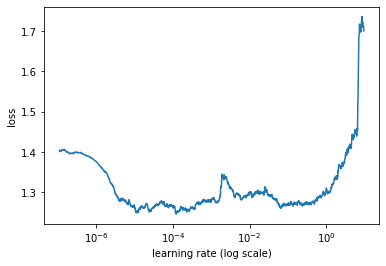

In [10]:
learner.lr_find(show_plot=True, max_epochs=2)

In [24]:
learner.fit_onecycle(5e-5, epochs=epochs, class_weight=class_weight_dict)



begin training using onecycle policy with max lr of 5e-05...
Train for 811 steps, validate for 143 steps
Epoch 1/4
811/811 [==============================] - 114s 140ms/step - loss: 1.3866 - accuracy: 0.2533 - val_loss: 1.3611 - val_accuracy: 0.3298
Epoch 2/4
811/811 [==============================] - 98s 121ms/step - loss: 1.3613 - accuracy: 0.2979 - val_loss: 1.3762 - val_accuracy: 0.3563
Epoch 3/4
811/811 [==============================] - 94s 116ms/step - loss: 1.2708 - accuracy: 0.3735 - val_loss: 1.4263 - val_accuracy: 0.3434
Epoch 4/4
811/811 [==============================] - 101s 124ms/step - loss: 0.9255 - accuracy: 0.5539 - val_loss: 1.7165 - val_accuracy: 0.3386


In [13]:
learner.view_top_losses(n=10, preproc=transformer)

----------
id:382 | loss:1.23 | true:equal | pred:more)

----------
id:454 | loss:1.23 | true:equal | pred:more)

----------
id:109 | loss:1.22 | true:equal | pred:more)

----------
id:608 | loss:1.22 | true:equal | pred:more)

----------
id:68 | loss:1.22 | true:equal | pred:more)

----------
id:720 | loss:1.22 | true:equal | pred:more)

----------
id:385 | loss:1.22 | true:equal | pred:more)

----------
id:520 | loss:1.22 | true:equal | pred:more)

----------
id:512 | loss:1.22 | true:equal | pred:more)

----------
id:761 | loss:1.21 | true:equal | pred:more)



In [25]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)

In [15]:
predictor.explain(x_train[741])

/home/sebastian/.local/lib/python3.8/site-packages/ktrain/text/predictor.py:112: UserWarning: ktrain requires a forked version of eli5 to support tf.keras. Install with: pip3 install git+https://github.com/amaiya/eli5@tfkeras_0_10_1
  warnings.warn(msg)


In [26]:
confusion = learner.evaluate()

              precision    recall  f1-score   support

           0       0.19      0.32      0.24       592
           1       0.50      0.37      0.43      1903
           2       0.40      0.33      0.36      1522
           3       0.16      0.26      0.20       558

    accuracy                           0.34      4575
   macro avg       0.31      0.32      0.31      4575
weighted avg       0.38      0.34      0.35      4575



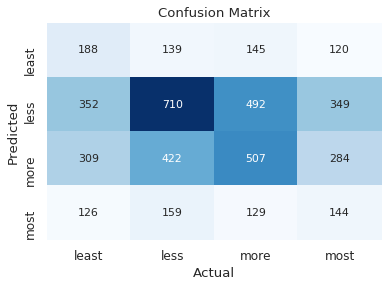

In [28]:
# print confusion matrix
import matplotlib.pyplot as plt
import seaborn as sn
labels = ['least','less','more','most']
cm_df = pd.DataFrame(confusion, labels, labels)
sn.set(font_scale=1.1, font='Arial')
ax = sn.heatmap(cm_df, cmap="Blues", annot=True, annot_kws={"size": 11}, cbar=False, fmt='g')
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted")
ax.set_title("Confusion Matrix")
plt.show()